In [1]:
import pandas as pd
import numpy as np
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import lightgbm as lgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
import joblib

In [2]:
DIR1 = "C:\\Users\\mehta\\Desktop\\kaggle\\feedback_phr_se\\"
N = 4
train = pd.read_csv(DIR1 + "train.csv")
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [3]:
train['count_nl'] = train['full_text'].apply(lambda x: len(x.split("\n\n")))

In [4]:
train.corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,count_nl
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151,0.031795
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025,-0.013293
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292,0.011447
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842,-0.001177
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301,-0.055071
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000,0.004938
count_nl,0.031795,-0.013293,0.011447,-0.001177,-0.055071,0.004938,1.000000


In [5]:
train.iloc[0,:]['full_text'].replace("\n\n", " [SEP] ")

"I think that students would benefit from learning at home,because they wont have to change and get up early in the morning to shower and do there hair. taking only classes helps them because at there house they'll be pay more attention. they will be comfortable at home. [SEP] The hardest part of school is getting ready. you wake up go brush your teeth and go to your closet and look at your cloths. after you think you picked a outfit u go look in the mirror and youll either not like it or you look and see a stain. Then you'll have to change. with the online classes you can wear anything and stay home and you wont need to stress about what to wear. [SEP] most students usually take showers before school. they either take it before they sleep or when they wake up. some students do both to smell good. that causes them do miss the bus and effects on there lesson time cause they come late to school. when u have online classes u wont need to miss lessons cause you can get everything set up an

In [6]:
###################################### compare previous data ##############################
DIR = "C:\\Users\\mehta\\Desktop\\kaggle\\feedback-prize-effectiveness\\"
train_2021 = pd.read_parquet(DIR + "fpe_21_train_essays.parquet")
train_2021.head()

,essay_id,essay_text
0,423A1CA112E2,Phones\n\nModern humans today are always on th...
1,A8445CABFECE,Phones & Driving\n\nDrivers should not be able...
2,6B4F7A0165B9,Cell Phone Operation While Driving\n\nThe abil...
3,E05C7F5C1156,People are debating whether if drivers should ...
4,50B3435E475B,Texting and driving\n\nOver half of drivers in...


In [7]:
train_2022 = pd.read_parquet(DIR + "fpe_22_train_essays.parquet")
train_2022.head()

,essay_id,essay_text
0,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h..."
1,00944C693682,Limiting the usage of cars has personal and pr...
2,00BD97EA4041,Should computers read the emotional expression...
3,00C6E82FE5BA,I think that it wouldn't be valueable to have ...
4,013B9AA6B9DB,"What is that thing on Mars?\n\nWell, some peop..."


In [8]:
train_2021['essay_text'].nunique(),train_2022['essay_text'].nunique()

(15594, 4191)

In [9]:
train['full_text'].nunique()

3911

In [10]:
len(set(train_2021['essay_text'].unique()) & set(train['full_text'].unique()))

103

In [11]:
len(set(train_2021['essay_id'].unique()) & set(train['text_id'].unique()))

452

In [12]:
common_ids = set(train_2021['essay_id'].unique()) & set(train['text_id'].unique())

In [13]:
train_2021[train_2021['essay_id'] == '00299B378633']

,essay_id,essay_text
7711,00299B378633,"Dear, Principal\n\nIf u change the school poli..."


In [14]:
train[train['text_id'].isin(common_ids)]

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,count_nl
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,4
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,2
5,004AC288D833,"Dear Principal,\r\n\r\nOur school should have ...",3.5,4.0,4.0,3.5,3.5,4.0,1
9,009F4E9310CB,Asking more than one person for and advice hel...,3.0,3.0,3.5,2.5,3.0,2.5,4
22,019BDC9DF7CD,Although some say students will not be benefit...,3.0,3.0,3.0,3.0,2.5,3.0,12
...,...,...,...,...,...,...,...,...,...
3882,FED42BB10805,"If you were looking for advice, would you take...",3.0,2.0,3.0,2.5,2.5,1.5,5
3885,FF13996AB0B3,Although some say schools shouldn't offer dist...,3.5,3.5,3.5,4.0,3.0,3.5,5
3887,FF197A6B15B2,Dear Principal my thoughts about having phone'...,3.0,2.5,3.0,2.5,3.0,2.5,2
3897,FF8BAC351714,I disagree with the students attend classes fo...,2.5,2.0,3.0,3.0,2.0,2.5,4


In [15]:
len(set(train_2021['essay_text'].unique()) & set(train_2022['essay_text'].unique()))

3847

In [16]:
len(set(train['full_text'].unique()) & set(train_2022['essay_text'].unique()))

22

In [17]:
train.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,count_nl
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,4
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,6
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,2
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,8
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,3


In [18]:
train_2021.head()

,essay_id,essay_text
0,423A1CA112E2,Phones\n\nModern humans today are always on th...
1,A8445CABFECE,Phones & Driving\n\nDrivers should not be able...
2,6B4F7A0165B9,Cell Phone Operation While Driving\n\nThe abil...
3,E05C7F5C1156,People are debating whether if drivers should ...
4,50B3435E475B,Texting and driving\n\nOver half of drivers in...


In [19]:
train['full_text'].nunique()

3911

In [20]:
train.drop(['text_id','full_text'], axis = 1).corr()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions,count_nl
cohesion,1.000000,0.695459,0.666151,0.690058,0.638689,0.666151,0.031795
syntax,0.695459,1.000000,0.680562,0.725467,0.709525,0.700025,-0.013293
vocabulary,0.666151,0.680562,1.000000,0.735261,0.654852,0.664292,0.011447
phraseology,0.690058,0.725467,0.735261,1.000000,0.719746,0.666842,-0.001177
grammar,0.638689,0.709525,0.654852,0.719746,1.000000,0.673301,-0.055071
conventions,0.666151,0.700025,0.664292,0.666842,0.673301,1.000000,0.004938
count_nl,0.031795,-0.013293,0.011447,-0.001177,-0.055071,0.004938,1.000000


In [21]:
train.groupby(['text_id']).apply(lambda x: len(x))

text_id
0016926B079C    1
0022683E9EA5    1
00299B378633    1
003885A45F42    1
0049B1DF5CCC    1
               ..
FFD29828A873    1
FFD9A83B0849    1
FFDC4011AC9C    1
FFE16D704B16    1
FFED00D6E0BD    1
Length: 3911, dtype: int64

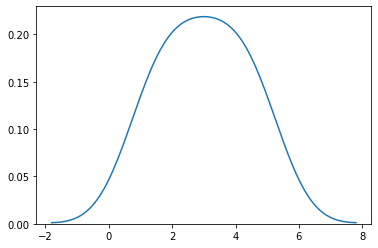

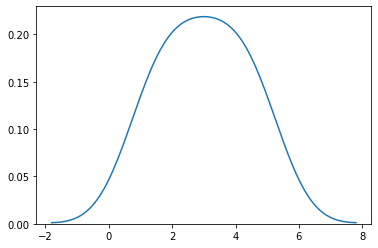

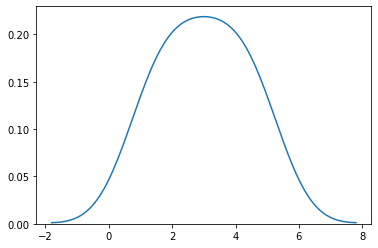

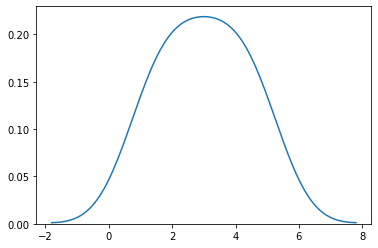

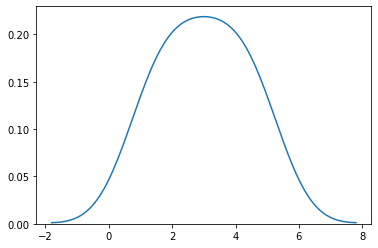

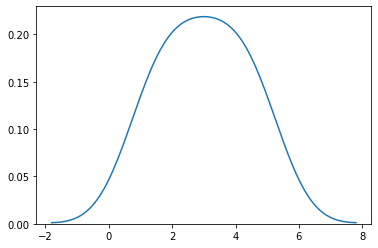

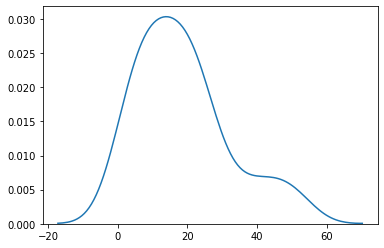

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
for col in train.drop(['text_id','full_text'], axis = 1):
    sns.kdeplot(train[col].unique())
    plt.show()

In [23]:
for col in train.drop(['text_id','full_text'], axis = 1):
    print(train[col].unique())

[3.5 2.5 3.  4.5 4.  2.  1.  5.  1.5]
[3.5 2.5 4.5 3.  4.  2.  1.  1.5 5. ]
[3.  4.5 4.  3.5 2.5 2.  5.  1.5 1. ]
[3.  2.  4.5 3.5 2.5 4.  5.  1.5 1. ]
[4.  2.  3.  2.5 3.5 4.5 5.  1.5 1. ]
[3.  2.5 5.  4.  2.  3.5 4.5 1.  1.5]
[ 4  6  2  8  3  1  7  5 14 11 12 10 17  9 22 15 18 13 44 23 26 21 28 16
 25 19 20 39 48 35 24 52]


In [24]:
map_class = {1:0, 1.5:1, 2:2, 2.5:3, 3:4, 3.5:5, 4:6, 4.5:7, 5:8}

for col in train.drop(['text_id','full_text'], axis = 1):
    train[col + "_class"] = train[col].map(map_class)

In [25]:
############################### split folds #################################

In [26]:
def create_folds(data, num_splits):
    data["kfold"] = -1

    mskf = MultilabelStratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    labels = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]
    data_labels = data[labels].values

    for f, (t_, v_) in enumerate(mskf.split(data, data_labels)):
        data.loc[v_, "kfold"] = f

    return data

In [27]:
data = create_folds(train, N)

In [28]:
import textstat

def text_stat_features(df):
    df['text_a'] = df['full_text'].apply(textstat.flesch_reading_ease)
    df['text_b'] = df['full_text'].apply(textstat.flesch_kincaid_grade)
    df['text_c'] = df['full_text'].apply(textstat.smog_index)
    df['text_d'] = df['full_text'].apply(textstat.coleman_liau_index)
    df['text_e'] = df['full_text'].apply(textstat.automated_readability_index)
    df['text_f'] = df['full_text'].apply(textstat.dale_chall_readability_score)
    df['text_g'] = df['full_text'].apply(textstat.difficult_words)
    df['text_h'] = df['full_text'].apply(textstat.linsear_write_formula)
    df['text_i'] = df['full_text'].apply(textstat.gunning_fog)
    df['text_j'] = df['full_text'].apply(textstat.text_standard)
    df['text_k'] = df['full_text'].apply(textstat.fernandez_huerta)
    df['text_l'] = df['full_text'].apply(textstat.szigriszt_pazos)
    df['text_m'] = df['full_text'].apply(textstat.gutierrez_polini)
    df['text_n'] = df['full_text'].apply(textstat.crawford)
    df['text_o'] = df['full_text'].apply(textstat.gulpease_index)
    df['text_p'] = df['full_text'].apply(textstat.osman)
    return df

data = text_stat_features(data)

In [29]:
features = [col for col in data if col.startswith("text") and "id" not in col and col != "text_j"]
len(features)

15

In [30]:
data[features]

,text_a,text_b,text_c,text_d,text_e,text_f,text_g,text_h,text_i,text_k,text_l,text_m,text_n,text_o,text_p
0,90.60,4.2,7.6,6.31,5.8,5.99,14,8.000000,6.57,120.05,115.71,49.65,1.2,67.2,79.81
1,66.64,13.4,11.9,5.93,16.2,2.45,12,11.200000,15.47,95.98,90.92,44.08,2.2,57.5,62.88
2,79.80,6.3,9.4,6.09,6.8,5.95,16,6.625000,7.22,111.70,109.98,49.69,1.7,64.8,78.51
3,76.35,7.6,8.3,7.72,9.6,5.66,39,6.571429,8.91,108.24,105.32,46.37,2.0,59.3,69.37
4,17.69,30.2,12.5,7.57,36.8,9.12,16,52.000000,31.88,49.28,50.03,28.35,2.5,51.9,17.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3906,52.46,14.7,10.8,8.89,17.4,8.69,25,17.333333,15.74,86.73,85.55,40.01,2.8,52.6,51.74
3907,54.70,13.9,12.5,9.47,16.8,7.69,54,14.000000,15.43,88.98,86.94,39.85,2.8,52.2,50.85
3908,72.73,11.1,8.5,6.34,13.7,6.83,15,17.666667,13.46,102.10,97.87,45.46,2.0,57.8,66.85
3909,63.73,10.4,12.1,8.83,12.1,6.39,35,15.250000,11.21,98.05,94.47,43.54,2.7,55.9,61.35


In [31]:
labels = ["cohesion", "syntax", "vocabulary", "phraseology", "grammar", "conventions"]

In [32]:
import scipy.sparse as SS

In [40]:
def get_mdl(train, test, target_type, fold):
    tfidf = TfidfVectorizer(max_features = None, max_df = 0.99, ngram_range=(1,3))
    
    corpus_train = train['full_text'].unique().tolist()
    corpus_test = test['full_text'].unique().tolist()
    
    tfidf.fit(corpus_train + corpus_test)
    
    x_train = tfidf.transform(corpus_train)
    x_test = tfidf.transform(corpus_test)
    x_train1 = train[features].values
    x_test1 = test[features].values
    
    x_train = SS.hstack((x_train, x_train1))
    x_test = SS.hstack((x_test, x_test1))
    
    y_train = train[target_type].values
    y_test = test[target_type].values
    
    model = lgb.LGBMRegressor(n_estimators = 100000, learning_rate = 0.008)
    model.fit(X = x_train, y = y_train, eval_set = [(x_train, y_train),(x_test, y_test)],\
             early_stopping_rounds=200, verbose=50)
    joblib.dump(model, 'lgb_model_{}_{}'.format(target_type, fold))
    pred_val = model.predict(x_test)
    print('mse score for class :{} is {}'.format(target_type, \
                                                  mean_squared_error(y_test,pred_val,\
                                                                    squared=False)))
    return pred_val, y_test

In [41]:
def MCRMSE(y_trues, y_preds):
    scores = []
    idxes = y_trues.shape[1]
    for i in range(idxes):
        y_true = y_trues[:,i]
        y_pred = y_preds[:,i]
        score = mean_squared_error(y_true, y_pred, squared=False) # RMSE
        scores.append(score)
    mcrmse_score = np.mean(scores)
    return mcrmse_score

In [ ]:
#################################### LGB MODEL #########################################
SCORE = []
for fold in range(N):
    
    train = data[data['kfold'] != fold].reset_index(drop = True)
    test = data[data['kfold'] == fold].reset_index(drop = True)
    
    preds = np.zeros((len(test), len(labels)))
    actuals = np.zeros((len(test), len(labels)))
    
    for i, target_type in enumerate(labels):
        print('fit', target_type)
        pred,actual = get_mdl(train, test, target_type, fold)
        preds[:,i] = pred
        actuals[:,i] = actual
    print('MCRMSE for fold is :{} is :{}'.format(fold, MCRMSE(actuals,preds)))
    test[['pred_' + col for col in labels]] = preds
    test.to_pickle("oof_LGB_fold_{}.pkl".format(fold))
    SCORE.append(MCRMSE(actuals,preds))

fit cohesion


C:\Users\mehta\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mehta\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
